In [2]:
#Import Libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS
import yfinance as yf
import seaborn
import matplotlib.pyplot as plt



In [5]:
#Fetch Historical Data from Yahoo Finance
symbol_list = ['PEP', 'KO']
data = yf.download(
    symbol_list, 
    start='2022-01-01', 
    end='2023-09-16'
)['Adj Close']

[*********************100%%**********************]  2 of 2 completed


In [16]:
S1 = data.KO
S2 = data.PEP

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1.KO
b = results.params['KO']
spread = S2 - b * S1  #b = Hedge ratio

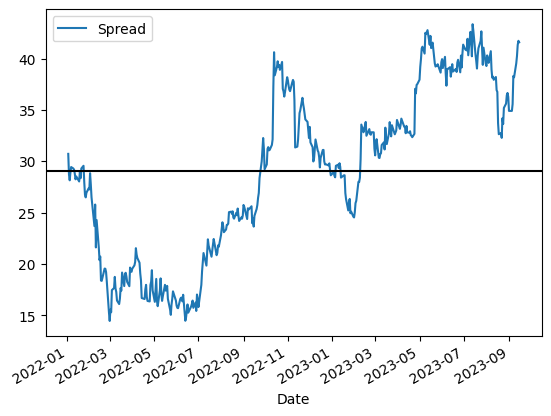

In [28]:
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread'])

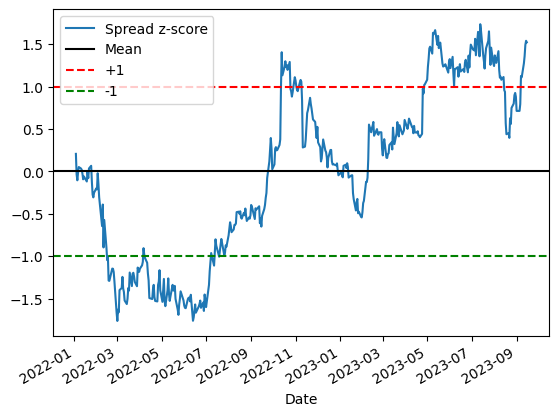

In [27]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

zscore(spread).plot() # For setting thresholds for buying and selling
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

In [29]:
# Create a DataFrame with the signal and position size in the pair
trades = pd.concat([zscore(spread), S2 - b * S1], axis=1)
trades.columns = ["signal", "position"]

# Add a long and short position at the z-score levels
trades["side"] = 0.0
trades.loc[trades.signal <= -1, "side"] = 1
trades.loc[trades.signal >= 1, "side"] = -1

<Axes: xlabel='Date'>

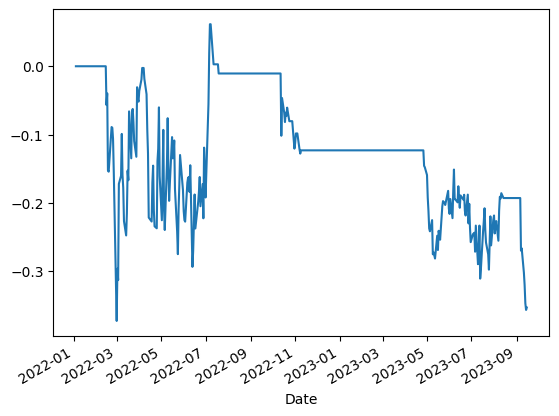

In [30]:
returns = trades.position.pct_change() * trades.side
returns.cumsum().plot() # Equity curve for the Pepsi-Coca Cola Pair